In [14]:
import pandas as pd
from sklearn.neighbors import KDTree
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, classification_report

In [15]:

data = pd.read_csv('glass.csv')
result_data = pd.read_csv('glass_result.csv')
data['Type'] = result_data['Type']

# Define a function to detect anomalies based on local density
def detect_anomalies(data, k=5, threshold=1.5):
    
    features = data.drop('Type', axis=1)
    labels_true = data['Type']
    
    # Create a KD-tree for fast nearest neighbor search
    tree = KDTree(features)
    
    # Calculate the average distance of k nearest neighbors with a density score
    dist, _ = tree.query(features, k=k+1)  # k+1 because the query point itself is included
    density_score = dist[:, 1:].mean(axis=1) 
    
    # Detect outliers where the density score exceeds the threshold
    anomalies = density_score > threshold
    labels_pred = anomalies.astype(int)
    
    # 计算准确率
    accuracy = accuracy_score(labels_true, labels_pred)

    print(classification_report(labels_true, labels_pred))
    print("\n")
    return labels_pred, accuracy


predicted_labels, accuracy = detect_anomalies(data)
print("Accuracy of the anomaly detection:", accuracy)



              precision    recall  f1-score   support

           0       0.97      0.90      0.93       205
           1       0.16      0.44      0.24         9

    accuracy                           0.88       214
   macro avg       0.57      0.67      0.58       214
weighted avg       0.94      0.88      0.90       214



Accuracy of the anomaly detection: 0.8785046728971962


In [16]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report



labels = data['Type']  
#features = data.drop('label', axis=1)
features=pd.read_csv('glass_result.csv')

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)


rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)


predictions = rf.predict(X_test)
print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00         3

    accuracy                           1.00        43
   macro avg       1.00      1.00      1.00        43
weighted avg       1.00      1.00      1.00        43



In [17]:
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score


data = pd.read_csv('glass.csv')
result_data = pd.read_csv('glass_result.csv')
data['Type'] = result_data['Type']

# Define functions that use LOF for exception detection
def detect_anomalies_lof(data, n_neighbors=28, contamination='auto'):
    
    features = data.drop('Type', axis=1)
    labels_true = data['Type']

   
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, novelty=False)
    
    
    labels_pred = lof.fit_predict(features)
    
    # LOF output -1 is abnormal, 1 is normal, converted to 0 is normal, and 1 is abnormal
    labels_pred = (labels_pred == -1).astype(int)
    

    accuracy = accuracy_score(labels_true, labels_pred)
    print(classification_report(labels_true, labels_pred))
    print("\n")
    return labels_pred, accuracy


predicted_labels, accuracy = detect_anomalies_lof(data)
print("Accuracy of the LOF anomaly detection:", accuracy)


              precision    recall  f1-score   support

           0       0.98      0.87      0.92       205
           1       0.18      0.67      0.29         9

    accuracy                           0.86       214
   macro avg       0.58      0.77      0.60       214
weighted avg       0.95      0.86      0.90       214



Accuracy of the LOF anomaly detection: 0.8598130841121495


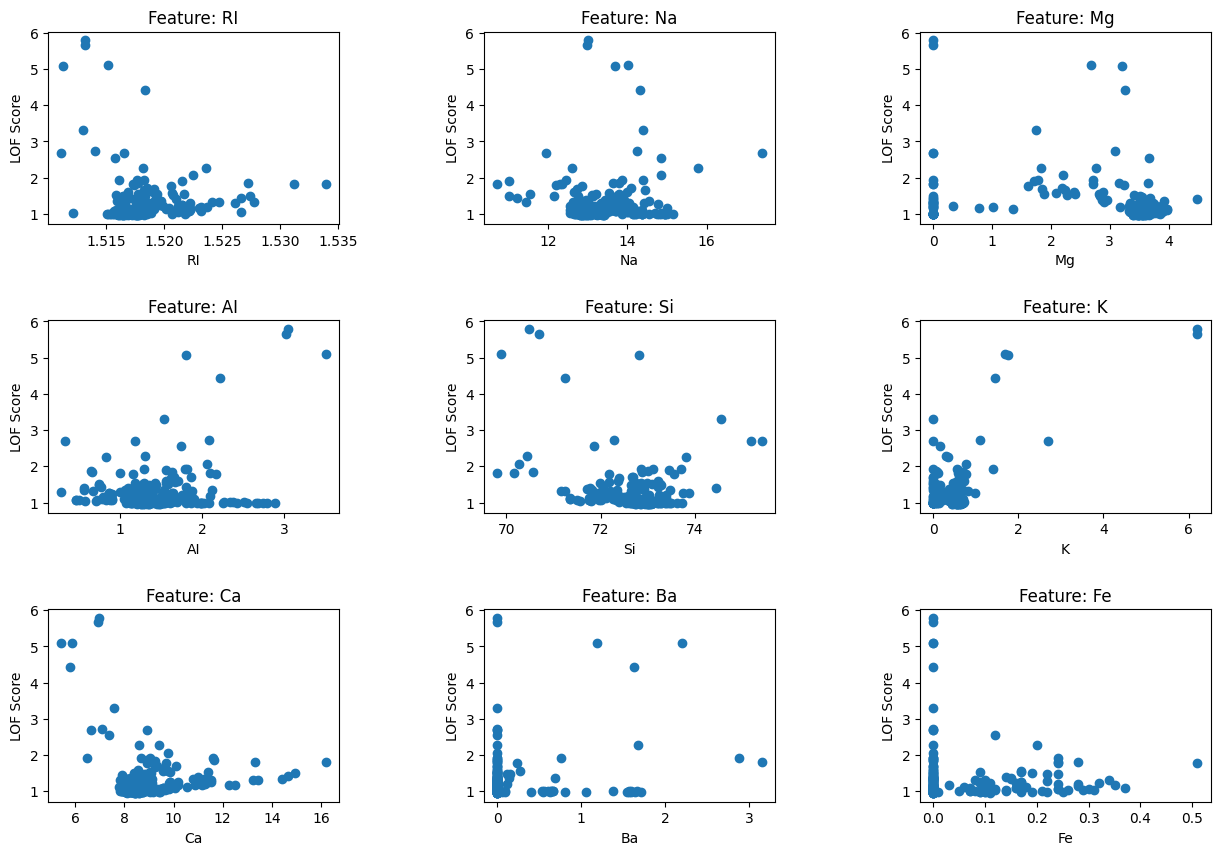

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

data = pd.read_csv('glass.csv')

lof = LocalOutlierFactor(n_neighbors=20)
lof.fit(data)
scores = -lof.negative_outlier_factor_  # Get the LOF score and take a negative for easier understanding (the higher the score, the more unusual)

data['LOF_Score'] = scores

# Plot the relationship between each feature and the LOF score
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
for ax, column in zip(axes.flatten(), data.columns[:-1]): 
    ax.scatter(data[column], data['LOF_Score'])
    ax.set_title(f'Feature: {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('LOF Score')

plt.show()


In [19]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import LocalOutlierFactor
from lime import lime_tabular


data = pd.read_csv('glass.csv')

lof = LocalOutlierFactor()
lof_scores = lof.fit_predict(data)
labels = (lof_scores == -1).astype(int)  

# Using random forests as a supervisory model
rf = RandomForestClassifier(n_estimators=100)
rf.fit(data, labels)


feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = data.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

# Using LIME to interpret an example of a random forest model
explainer = lime_tabular.LimeTabularExplainer(training_data=data.to_numpy(),
                                              feature_names=data.columns,
                                              class_names=['Normal', 'Anomaly'],
                                              mode='classification')
exp = explainer.explain_instance(data.iloc[0].to_numpy(), rf.predict_proba, num_features=9)
exp.show_in_notebook(show_table=True)


    importance
Mg    0.288547
Ca    0.158349
K     0.150968
Na    0.116681
Si    0.116570
RI    0.075391
AI    0.055098
Ba    0.021076
Fe    0.017321


D:\anaconda\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [20]:

data = pd.read_csv('glass.csv')
result_data = pd.read_csv('glass_result.csv')


data_with_labels = data.copy()
data_with_labels['Type'] = result_data['Type']

# Delete the 'ai' and 'Fe' columns
data_reduced = data.drop(['AI', 'Fe'], axis=1)

# Re-anomaly detection using LOF
lof_reduced = LocalOutlierFactor(n_neighbors=20)
labels_pred_reduced = lof_reduced.fit_predict(data_reduced)


labels_pred_reduced = (labels_pred_reduced == -1).astype(int)


accuracy_reduced = accuracy_score(data_with_labels['Type'], labels_pred_reduced)
print(accuracy_reduced)
print(classification_report(data_with_labels['Type'], labels_pred_reduced))



0.8317757009345794
              precision    recall  f1-score   support

           0       0.98      0.84      0.91       205
           1       0.15      0.67      0.25         9

    accuracy                           0.83       214
   macro avg       0.57      0.75      0.58       214
weighted avg       0.95      0.83      0.88       214



In [21]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import LocalOutlierFactor
from lime import lime_tabular


data =data_reduced


lof = LocalOutlierFactor()
lof_scores = lof.fit_predict(data)
labels = (lof_scores == -1).astype(int)  


rf = RandomForestClassifier(n_estimators=100)
rf.fit(data, labels)


feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = data.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)


explainer = lime_tabular.LimeTabularExplainer(training_data=data.to_numpy(),
                                              feature_names=data.columns,
                                              class_names=['Normal', 'Anomaly'],
                                              mode='classification')
exp = explainer.explain_instance(data.iloc[0].to_numpy(), rf.predict_proba, num_features=9)
exp.show_in_notebook(show_table=True)


    importance
Mg    0.241337
Na    0.192124
Ca    0.150274
Si    0.145345
K     0.143040
RI    0.097413
Ba    0.030467


D:\anaconda\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

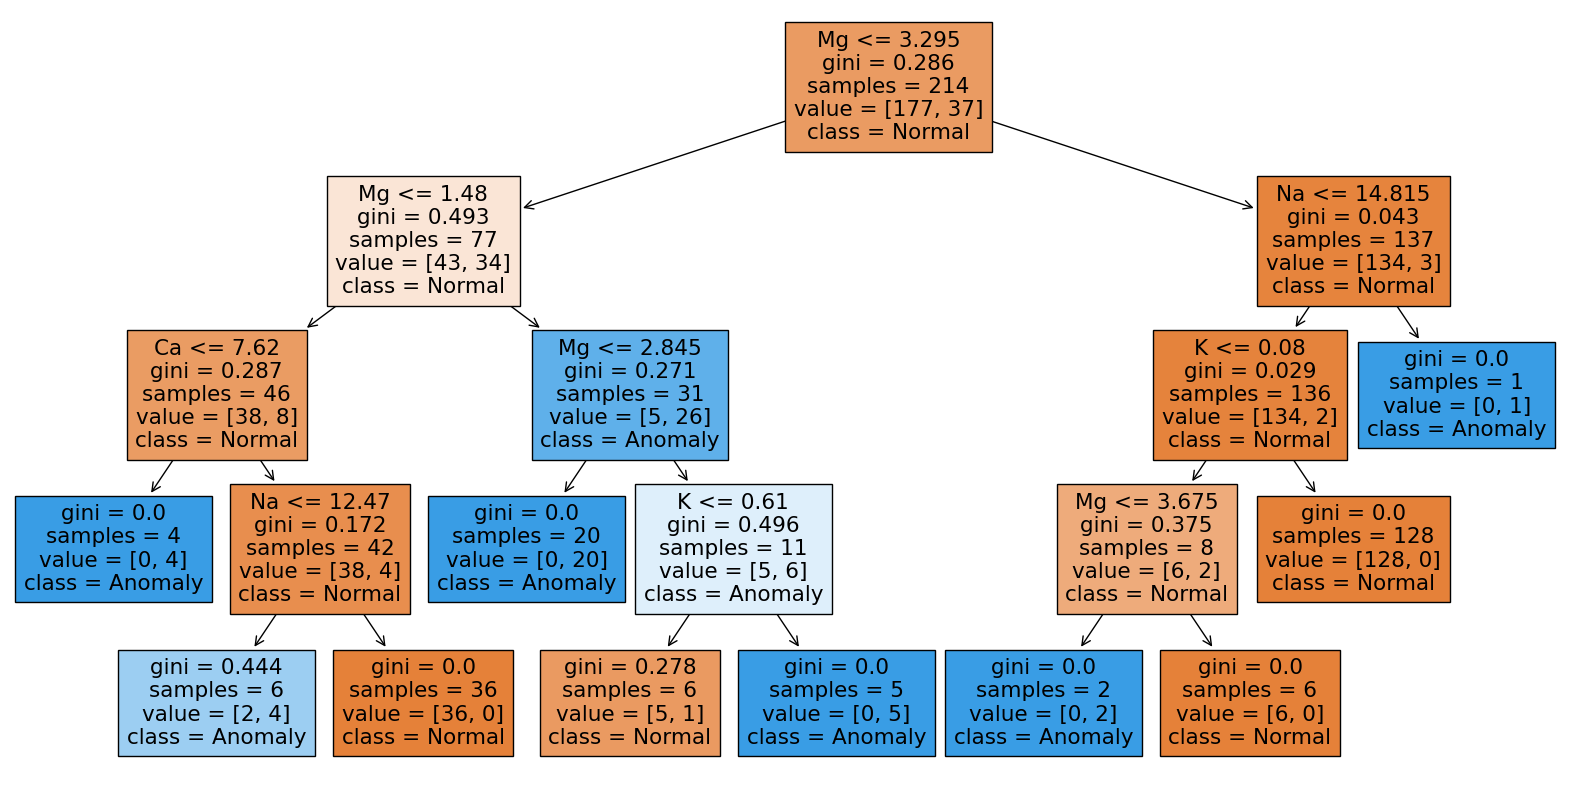

In [23]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

data = pd.read_csv('glass.csv')


lof = LocalOutlierFactor(n_neighbors=20)
labels = lof.fit_predict(data)

binary_labels = (labels == -1).astype(int)

tree_model = DecisionTreeClassifier(max_depth=4)  # Limit tree depth for visualization
tree_model.fit(data, binary_labels)

feature_names = data.columns.tolist()
plt.figure(figsize=(20,10))

plot_tree(tree_model, filled=True, feature_names=feature_names, class_names=["Normal", "Anomaly"])
plt.show()


This decision tree is consistent with the importance of the previous feature